# Import packages and data

In [306]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from category_encoders import OrdinalEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

In [2]:
POLICY_DATA = '../data/datastorm_policy_data.csv'
AGENT_DATA = '../data/datastorm_agent_data.csv'

In [533]:
df = pd.read_csv(POLICY_DATA, parse_dates=['next_due_dt', 'termination_dt', 
                                           'main_holder_dob', 'spouse_dob', 
                                           'child1_dob', 'child2_dob', 
                                           'child3_dob', 'child4_dob', 
                                           'child5_dob', 
                                           'run_date', 'commencement_dt'])

c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [86]:
df = df.drop(columns=['main_holder_occupation_cd', 'product_code'])

In [341]:
df = df[df.policy_snapshot_as_on != 20190831]

In [342]:
df

,policy_term,policy_payment_mode,policy_status,commencement_dt,next_due_dt,termination_dt,termination_reason,main_holder_gender,main_holder_dob,main_holder_entry_age,...,child5_dob,child5_gender,payment_method,main_holder_occupation,policy_snapshot_as_on,run_date,client_code,agent_code,product_name,policy_code
0,20,M,INFORCE,2011/08/21,2019-02-21,NaT,NaN,M,1983-10-01,28,...,NaT,NaN,CASH,NaN,20190131,2020-07-01,C108223,AG108847,HEALTH,POL28535
1,15,M,INFORCE,2006/07/14,2019-09-14,NaT,NaN,F,1958-01-01,48,...,NaT,NaN,CASH,BUSINESSMAN,20190901,2020-07-01,C103349,AG103677,RETIREMENT,POL27771
2,20,Y,INFORCE,2018/12/28,2019-12-28,NaT,NaN,M,1967-11-01,51,...,NaT,NaN,CASH,RECYCLE RACERS,20191101,2020-07-01,C120388,AG103249,INVESTMENT,POL29786
3,15,Q,INFORCE,2018/11/06,2020-02-06,NaT,NaN,M,1989-10-01,29,...,NaT,NaN,CHEQUE,RECEPTIONIST,20191201,2020-07-01,C113155,AG106733,HEALTH,POL24635
4,15,M,LAPSED,2012/04/28,2015-06-28,NaT,OTHERS,M,1988-05-01,24,...,NaT,NaN,CASH,BUSINESSMAN,20190228,2020-07-01,C106155,AG106907,HEALTH,POL7470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631417,15,M,INFORCE,2012/08/21,2020-05-21,NaT,NaN,M,1981-07-01,31,...,NaT,NaN,CASH,MAHOUTS,20200601,2020-07-01,C109432,AG101538,HEALTH,POL14777
631418,18,M,LAPSED,2016/01/21,2020-01-21,NaT,NaN,M,1982-11-01,33,...,NaT,NaN,CASH,BUSINESSMAN,20200601,2020-07-01,C113916,AG107717,INVESTMENT,POL7988
631419,15,M,INFORCE,2008/05/21,2020-06-21,NaT,NaN,M,1958-05-01,50,...,NaT,NaN,CASH,QUARRYMEN,20200601,2020-07-01,C104807,AG100394,HEALTH,POL0263
631420,20,M,INFORCE,2019/08/16,2020-06-16,NaT,NaN,F,1992-10-01,27,...,NaT,NaN,CHEQUE,NaN,20200601,2020-07-01,C148592,AG107517,INVESTMENT,POL17804


# Create Labels

In [503]:
def create_labels(df, train_snap_date, label_last_date):
    snap_df = df[(df.policy_snapshot_as_on == train_snap_date) 
                    & (df.policy_status == 'INFORCE')][['client_code', 
                                                        'policy_code', 
                                                        'product_name']]
    cust_df = df[(df.policy_snapshot_as_on == train_snap_date)][[
        'client_code']].drop_duplicates().set_index('client_code')

    label_df = df[(df.policy_snapshot_as_on > train_snap_date) 
                     & (df.policy_snapshot_as_on <= label_last_date) 
                     & (df.policy_status == 'INFORCE')][['client_code', 
                                                         'product_name', 
                                                         'policy_code', 
                                                         'policy_snapshot_as_on']]
    
    join_df = label_df.merge(snap_df[['policy_code', 'client_code']], 
                             on=['policy_code', 'client_code'], how='left', 
                             indicator=True)
    join_df['is_prev'] = join_df._merge.map({'left_only':0, 'both':1}).astype(int)
    
    #customers who can be c
    cross_sell_eligible = join_df.groupby(['client_code', 
                                           'policy_snapshot_as_on']).is_prev.sum()
    
    cross_sell_eligible.name = 'cross_sell_eligible'
    cross_sell_eligible = cross_sell_eligible[cross_sell_eligible > 0].reset_index()
    
    joined_cs_eligible = join_df.merge(cross_sell_eligible, 
                                       on=['client_code', 
                                           'policy_snapshot_as_on'], 
                                       how='left').dropna()
    
    labels = joined_cs_eligible[joined_cs_eligible.is_prev == 0][[
        'client_code', 'product_name']].drop_duplicates()
    labels['value'] = 1
    pivot_labels = labels.pivot_table(values='value', index='client_code', 
                                      aggfunc='sum',
                                      columns='product_name').fillna(0).astype(int)

    return cust_df.merge(pivot_labels, on='client_code', how='left').fillna(0)


# Create Client Dataset

In [566]:
def client_dataset(df, snap_date):
    df_snap = df[(df.policy_snapshot_as_on == snap_date)]
    
    customer_specific_features = ['main_holder_gender', 'main_holder_dob',
                               'main_holder_smoker_flag', 'spouse_gender',
                               'spouse_dob', 'spouse_smoker_flag',
                               'child1_dob', 'child1_gender', 'child2_dob',
                               'child2_gender', 'child3_dob', 'child3_gender', 
                               'child4_dob', 'child4_gender', 'child5_dob', 
                               'child5_gender', 'main_holder_occupation', 
                               'client_code']
    
    df_cust = df_snap[customer_specific_features]

    dob_feat = ['main_holder_dob', 'spouse_dob', 'child1_dob', 'child2_dob',
           'child3_dob', 'child4_dob', 'child5_dob']

    age_feat = []
    for col in dob_feat:
        new_col = col[:-4] + '_age'
        df_cust[new_col] = pd.to_datetime(
            snap_date, format='%Y%m%d').year - df_cust[col].dt.year
        df_cust = df_cust.drop(columns=col)
        age_feat.append(new_col)

    df_cust_numeric = df_cust.groupby('client_code')[age_feat].median()

    df_cust_cat = df_cust.select_dtypes('object').groupby('client_code').first()

    df_cust_fin = df_cust_cat.join(df_cust_numeric)
    
    pivot_cols = ['policy_payment_mode', 'policy_status']
    
    for col in pivot_cols:
        df_filt = df_snap[['client_code'] + [col]].copy()
        df_filt['value'] = 1
        df_pivot = df_filt.pivot_table(values='value', 
                                       index='client_code', aggfunc='sum', 
                                       columns=col).fillna(0).astype(int)
        df_cust_fin =df_cust_fin.join(
            df_pivot.divide(df_pivot.sum(axis=1), axis=0), how='left')
    
    #policy age
    df_policy_age = df_snap[['client_code', 'policy_snapshot_as_on', 'commencement_dt']]
    df_policy_age['policy_age'] = pd.cut(((pd.to_datetime(df_snap.policy_snapshot_as_on, format='%Y%m%d') - df_snap.commencement_dt).dt.days/365), bins=[0,1,5,10,40], labels=['policy_age_1_yr', 'policy_age_5_yr', 'policy_age_10_yr', 'policy_age_40_yr'])
    df_policy_age = df_policy_age.drop(columns=['policy_snapshot_as_on', 'commencement_dt'])
    df_policy_age['value'] = 1
    df_pivot = df_policy_age.pivot_table(values='value', 
                                           index='client_code', aggfunc='sum', 
                                       columns='policy_age').fillna(0).astype(int)
    df_cust_fin = df_cust_fin.join(
        df_pivot.divide(df_pivot.sum(axis=1), axis=0), how='left')
    
    return df_cust_fin

In [505]:
client_dataset(df, snap_date)

c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,main_holder_gender,main_holder_smoker_flag,spouse_gender,spouse_smoker_flag,child1_gender,child2_gender,child3_gender,child4_gender,child5_gender,main_holder_occupation,...,child4_age,child5_age,H,M,Q,S,Y,INFORCE,LAPSED,TERMINATED
client_code,,,,,,,,,,,,,,,,,,,,,
C100000,M,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FLOUR & GRAIN MILL W,...,NaN,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
C100001,M,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHENA CULTIVATOR,...,NaN,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
C100002,M,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FLOUR & GRAIN MILL W,...,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
C100003,F,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MINISTER,...,NaN,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
C100004,F,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MINISTER,...,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C154442,M,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BUSINESSMAN,...,NaN,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
C154444,M,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEDICAL REPRESENTATI,...,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
C154445,M,N,F,N,F,F,NaN,NaN,NaN,AUDIOLOGIST,...,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [536]:
df_snap = df[(df.policy_snapshot_as_on == snap_date)]

In [525]:
df_snap.columns

Index(['policy_term', 'policy_payment_mode', 'policy_status',
       'commencement_dt', 'next_due_dt', 'termination_dt',
       'termination_reason', 'main_holder_gender', 'main_holder_dob',
       'main_holder_entry_age', 'main_holder_smoker_flag', 'spouse_gender',
       'spouse_dob', 'spouse_entry_age', 'spouse_smoker_flag',
       'total_sum_assuared', 'premium_value', 'rider1_prem',
       'rider1_sum_assuared', 'rider2_prem', 'rider2_sum_assuared',
       'rider3_prem', 'rider3_sum_assuared', 'rider4_prem',
       'rider4_sum_assuared', 'rider5_prem', 'rider5_sum_assuared',
       'rider6_prem', 'rider6_sum_assuared', 'rider7_prem',
       'rider7_sum_assuared', 'rider8_prem', 'rider8_sum_assuared',
       'rider9_prem', 'rider9_sum_assuared', 'rider10_prem',
       'rider10_sum_assuared', 'child1_dob', 'child1_gender', 'child2_dob',
       'child2_gender', 'child3_dob', 'child3_gender', 'child4_dob',
       'child4_gender', 'child5_dob', 'child5_gender', 'payment_method',
      

In [541]:
df_snap.commencement_dt 

8        2010-09-21
50       2018-10-05
67       1994-03-28
105      2017-05-28
120      2016-12-28
            ...    
631399   2013-08-07
631404   2017-09-28
631408   2018-10-16
631411   2014-03-21
631412   2015-02-21
Name: commencement_dt, Length: 26616, dtype: datetime64[ns]

In [580]:
df_next_due = df_snap[['client_code', 'policy_snapshot_as_on', 'next_due_dt']]

c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

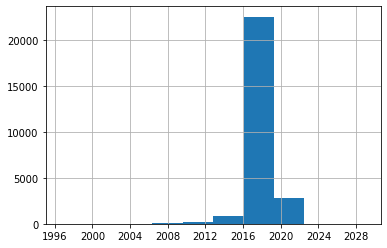

In [582]:
df_next_due.next_due_dt.hist()

In [ ]:
df_next_due = df_snap[['client_code', 'policy_snapshot_as_on', 'next_due_date']]

df_next_due['policy_age'] = pd.cut(((pd.to_datetime(df_snap.policy_snapshot_as_on, format='%Y%m%d') - df_snap.next_due_date).dt.days/365), bins=[0,1,5,10,40], labels=['policy_age_1_yr', 'policy_age_5_yr', 'policy_age_10_yr', 'policy_age_40_yr'])

df_policy_age = df_policy_age.drop(columns=['policy_snapshot_as_on', 'commencement_dt'])

df_policy_age['value'] = 1
df_pivot = df_policy_age.pivot_table(values='value', 
                                       index='client_code', aggfunc='sum', 
                                       columns='policy_age').fillna(0).astype(int)
df_pivot.divide(df_pivot.sum(axis=1), axis=0)

In [554]:
df_policy_age = df_snap[['client_code', 'policy_snapshot_as_on', 'commencement_dt']]

df_policy_age['policy_age'] = pd.cut(((pd.to_datetime(df_snap.policy_snapshot_as_on, format='%Y%m%d') - df_snap.commencement_dt).dt.days/365), bins=[0,1,5,10,40], labels=['policy_age_1_yr', 'policy_age_5_yr', 'policy_age_10_yr', 'policy_age_40_yr'])

df_policy_age = df_policy_age.drop(columns=['policy_snapshot_as_on', 'commencement_dt'])

df_policy_age['value'] = 1
df_pivot = df_policy_age.pivot_table(values='value', 
                                       index='client_code', aggfunc='sum', 
                                       columns='policy_age').fillna(0).astype(int)
df_pivot.divide(df_pivot.sum(axis=1), axis=0)

In [467]:
df_p

,client_code,policy_status,value
8,C107145,INFORCE,1
50,C120466,INFORCE,1
67,C101690,INFORCE,1
105,C115813,LAPSED,1
120,C116685,INFORCE,1
...,...,...,...
631399,C110790,INFORCE,1
631404,C117934,INFORCE,1
631408,C120592,INFORCE,1
631411,C111599,INFORCE,1


In [484]:
for col in pivot_cols:
    df_filt = df_snap[['client_code'] + [col]].copy()
    df_filt['value'] = 1
    df_pivot = df_filt.pivot_table(values='value', index='client_code', aggfunc='sum', columns=col).fillna(0).astype(int)
    print(df_pivot.divide(df_pivot.sum(axis=1), axis=0))

policy_payment_mode    H    M    Q    S    Y
client_code                                 
C100000              0.0  1.0  0.0  0.0  0.0
C100001              0.0  1.0  0.0  0.0  0.0
C100002              0.0  0.0  0.0  0.0  1.0
C100003              1.0  0.0  0.0  0.0  0.0
C100004              0.0  0.0  0.0  0.0  1.0
...                  ...  ...  ...  ...  ...
C154442              0.0  1.0  0.0  0.0  0.0
C154444              0.0  1.0  0.0  0.0  0.0
C154445              0.0  1.0  0.0  0.0  0.0
C154446              0.0  1.0  0.0  0.0  0.0
C154448              0.0  0.0  0.0  0.0  1.0

[22262 rows x 5 columns]
policy_status  INFORCE  LAPSED  TERMINATED
client_code                               
C100000            1.0     0.0         0.0
C100001            1.0     0.0         0.0
C100002            1.0     0.0         0.0
C100003            1.0     0.0         0.0
C100004            1.0     0.0         0.0
...                ...     ...         ...
C154442            1.0     0.0         0.0
C1

In [470]:
df_policy_pivot/df_policy_pivot.sum(axis=1)

,C100000,C100001,C100002,C100003,C100004,C100005,C100006,C100007,C100008,C100009,...,C154440,C154441,C154442,C154444,C154445,C154446,C154448,INFORCE,LAPSED,TERMINATED
client_code,,,,,,,,,,,,,,,,,,,,,
C100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C100001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C100002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C100003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C100004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C154442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C154444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C154445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [476]:
df_policy_pivot


policy_status,INFORCE,LAPSED,TERMINATED
client_code,,,
C100000,1,0,0
C100001,1,0,0
C100002,1,0,0
C100003,1,0,0
C100004,1,0,0
...,...,...,...
C154442,1,0,0
C154444,0,1,0
C154445,0,1,0


In [478]:
df_policy_pivot.divide(df_policy_pivot.sum(axis=1), axis=0)

1.0

In [448]:
df.policy_payment_mode

0         M
1         M
2         Y
3         Q
4         M
         ..
631417    M
631418    M
631419    M
631420    M
631421    M
Name: policy_payment_mode, Length: 600366, dtype: object

In [445]:
df.policy_term

0         20
1         15
2         20
3         15
4         15
          ..
631417    15
631418    18
631419    15
631420    20
631421    20
Name: policy_term, Length: 600366, dtype: int64

In [191]:
snap_date = 20181231

In [203]:
df_snap = df[(df.policy_snapshot_as_on == snap_date) & (df.policy_status == 'INFORCE')]

In [204]:
customer_specific_features = ['main_holder_gender', 'main_holder_dob',
                              'main_holder_smoker_flag', 'spouse_gender',
                               'spouse_dob', 'spouse_smoker_flag',
                               'child1_dob', 'child1_gender', 'child2_dob',
                               'child2_gender', 'child3_dob', 'child3_gender', 'child4_dob',
                               'child4_gender', 'child5_dob', 'child5_gender',
                               'main_holder_occupation', 
                               'client_code']

In [210]:
df_cust = df_snap[customer_specific_features]

dob_feat = ['main_holder_dob', 'spouse_dob', 'child1_dob', 'child2_dob',
       'child3_dob', 'child4_dob', 'child5_dob']

age_feat = []
for col in dob_feat:
    new_col = col[:-4] + '_age'
    df_cust[new_col] = pd.to_datetime(snap_date, format='%Y%m%d').year - df_cust[col].dt.year
    df_cust = df_cust.drop(columns=col)
    age_feat.append(new_col)

df_cust_numeric = df_cust.groupby('client_code')[age_feat].median()

df_cust_cat = df_cust.select_dtypes('object').groupby('client_code').first()

df_cust_fin = df_cust_cat.join(df_cust_numeric)

In [211]:
df_cust_fin

,main_holder_gender,main_holder_smoker_flag,spouse_gender,spouse_smoker_flag,child1_gender,child2_gender,child3_gender,child4_gender,child5_gender,main_holder_occupation,main_holder_age,spouse_age,child1_age,child2_age,child3_age,child4_age,child5_age
client_code,,,,,,,,,,,,,,,,,
C100000,M,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FLOUR & GRAIN MILL W,27.0,NaN,NaN,NaN,NaN,NaN,NaN
C100001,M,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHENA CULTIVATOR,37.0,NaN,NaN,NaN,NaN,NaN,NaN
C100002,M,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FLOUR & GRAIN MILL W,24.0,NaN,NaN,NaN,NaN,NaN,NaN
C100003,F,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MINISTER,27.0,NaN,NaN,NaN,NaN,NaN,NaN
C100004,F,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MINISTER,46.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C154407,F,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SALESMAN,39.0,NaN,NaN,NaN,NaN,NaN,NaN
C154416,F,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SALESMAN,30.0,NaN,NaN,NaN,NaN,NaN,NaN
C154436,F,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,NaN,NaN,NaN,NaN,NaN,NaN


# Fill NA values

In [228]:
def fillna_vals(df_cust):
    cat_cols = ['main_holder_gender', 'main_holder_smoker_flag', 'spouse_gender',
       'spouse_smoker_flag', 'child1_gender', 'child2_gender', 'child3_gender',
       'child4_gender', 'child5_gender', 'main_holder_occupation']

    df_cust[cat_cols] = df_cust[cat_cols].fillna('unk')

    zero_fill_cols = ['spouse_age', 'child1_age', 'child2_age',
           'child3_age', 'child4_age', 'child5_age']
    df_cust[zero_fill_cols] = df_cust[zero_fill_cols].fillna(0)
    
    return df_cust

# Categorical Encoding

In [282]:
def cat_encoding(df_cust):
    cat_cols = ['main_holder_gender', 'main_holder_smoker_flag', 'spouse_gender',
           'spouse_smoker_flag', 'child1_gender', 'child2_gender', 'child3_gender',
           'child4_gender', 'child5_gender', 'main_holder_occupation']

    cat_enc = OrdinalEncoder(cols=cat_cols, verbose=False)

    cat_enc.fit(df_cust)

    df_cust = cat_enc.transform(df_cust)
    
    return df_cust

# Create Train Dataset

In [289]:
def create_train_set(df, snap_date, last_label_date):
    df_labels = create_labels(df, snap_date, last_label_date)

    df_cust = client_dataset(df, snap_date)

    df_cust = fillna_vals(df_cust)
    
    df_cust = cat_encoding(df_cust)

    df_cross_sell = (df_labels.sum(axis=1) > 0).astype(int)
    df_cross_sell.name = 'is_cross_sell'

    return df_cust.join(df_cross_sell)

In [284]:
snap_date = 20181231
last_label_date = 20190630

In [285]:
df_labels = create_labels(df, snap_date, last_label_date)

df_cust = client_dataset(df, snap_date)

df_cust = fillna_vals(df_cust)

df_cross_sell = (df_labels.sum(axis=1) > 0).astype(int)
df_cross_sell.name = 'is_cross_sell'

df_train_test = df_cust.join(df_cross_sell)

c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Model Training

In [290]:
policy_snaps = sorted(df.policy_snapshot_as_on.unique())

In [313]:
policy_snaps

[20181231,
 20190131,
 20190228,
 20190331,
 20190430,
 20190531,
 20190630,
 20190731,
 20190831,
 20190901,
 20191001,
 20191101,
 20191201,
 20200101,
 20200201,
 20200301,
 20200401,
 20200501,
 20200601,
 20200701]

# Train/test datasets

train/test selected so that there are no overlapping time regions

In [567]:
df_train = pd.concat([create_train_set(df, policy_snaps[0], policy_snaps[6]),
#                       create_train_set(df, policy_snaps[1], policy_snaps[7]),
#                       create_train_set(df, policy_snaps[2], policy_snaps[8]),
#                       create_train_set(df, policy_snaps[3], policy_snaps[9]),
#                       create_train_set(df, policy_snaps[4], policy_snaps[10]),
#                       create_train_set(df, policy_snaps[5], policy_snaps[11]),
#                       create_train_set(df, policy_snaps[6], policy_snaps[12])
                     ])

c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [568]:
policy_snaps[19]

20200701

In [569]:
df_train.is_cross_sell.value_counts(dropna=False)

0    21737
1      525
Name: is_cross_sell, dtype: int64

In [570]:
df_test = create_train_set(df, policy_snaps[13], policy_snaps[19])

c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [571]:
train_X = df_train.drop(columns='is_cross_sell')
train_y = df_train['is_cross_sell']

test_X = df_test.drop(columns='is_cross_sell')
test_y = df_test['is_cross_sell']

In [572]:
model = LGBMClassifier(n_jobs=-1, n_estimators=500, max_depth=10, class_weight='balanced', num_leaves=7)
model.fit(train_X, train_y)

pred_y = model.predict(test_X)
pred_y_prob = model.predict_proba(test_X)[:,1]

pred_y_train = model.predict(train_X)
pred_y_train_prob = model.predict_proba(train_X)[:,1]

In [573]:
print(confusion_matrix(test_y, pred_y))

[[23643  3203]
 [  351   216]]


In [574]:
print(classification_report(train_y, pred_y_train))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93     21737
           1       0.14      0.89      0.24       525

    accuracy                           0.86     22262
   macro avg       0.57      0.88      0.58     22262
weighted avg       0.98      0.86      0.91     22262



In [575]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     26846
           1       0.06      0.38      0.11       567

    accuracy                           0.87     27413
   macro avg       0.52      0.63      0.52     27413
weighted avg       0.97      0.87      0.91     27413



In [576]:
print(roc_auc_score(train_y, pred_y_train_prob))

0.951504018822416


In [577]:
print(roc_auc_score(test_y, pred_y_prob))

0.7348990407236204


# Model Explanations

In [578]:
pd.Series(model.feature_importances_, index=train_X.columns).sort_values(ascending=False)

main_holder_age            664
main_holder_occupation     651
spouse_age                 239
child1_age                 139
LAPSED                     112
policy_age_1_yr            105
policy_age_10_yr           102
INFORCE                     99
policy_age_40_yr            90
policy_age_5_yr             88
child2_age                  82
Y                           81
main_holder_gender          74
Q                           74
M                           53
H                           47
S                           46
child1_gender               46
TERMINATED                  41
main_holder_smoker_flag     35
spouse_gender               32
child2_gender               31
child3_age                  30
spouse_smoker_flag          23
child3_gender               16
child4_age                   0
child5_age                   0
child5_gender                0
child4_gender                0
dtype: int32